<a href="https://colab.research.google.com/github/gc2321/3546-Deep-Learning/blob/main/assign_2/assign_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Flowers using Transfer Learning in Keras

Assignment 2 - Convolutional Neural Nets and Transfer Learning

By Gordon Chan (qq525548)


In [107]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(42)


In [108]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [109]:
data_dir = "/content/gdrive/MyDrive/3546/assign_2/flower_photos"

In [110]:
os.listdir(data_dir)

['tulips', 'roses', 'sunflowers', 'dandelion', 'daisy']

In [111]:
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Loading data

In [112]:
from sklearn.model_selection import train_test_split

# Get the list of classes (folders)
classes = ['tulips', 'roses', 'sunflowers', 'dandelion', 'daisy']

# Initialize the lists to store the images and labels
images = []
labels = []

# Loop through each class folder
for class_ in classes:
    # Get the list of images in the current class folder
    image_paths = tf.io.gfile.glob(f'{data_dir}/{class_}/*.jpg')

    # Loop through each image
    for image_path in image_paths:
        # Read the image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)

        # Add the image and label to the lists
        images.append(image)
        labels.append(class_)

# Split the data into training and testing sets (80% for training and 20% for testing)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Print the shapes of the training and testing sets
print(f'Training images shape: {len(train_images)}')
print(f'Testing images shape: {len(test_images)}')

Training images shape: 2936
Testing images shape: 734


In [113]:
# split off 15% of training set as validation set
validation_images, remaining_images, validation_labels, remaining_labels = train_test_split(
    train_images, train_labels, test_size=0.85, random_state=42, stratify=train_labels
)

# Update the training data to be the remaining images and labels
train_images = remaining_images
train_labels = remaining_labels

In [114]:
print(f'Training images shape: {len(train_images)}')
print(f'Validation images shape: {len(validation_images)}')
print(f'Testing images shape: {len(test_images)}')

Training images shape: 2496
Validation images shape: 440
Testing images shape: 734


In [115]:
def show_images(images, num, labels):
    plt.figure(figsize=(10, 10))
    for i in range(num):
      plt.subplot(3, 3, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      plt.xlabel(labels[i])
    plt.show()

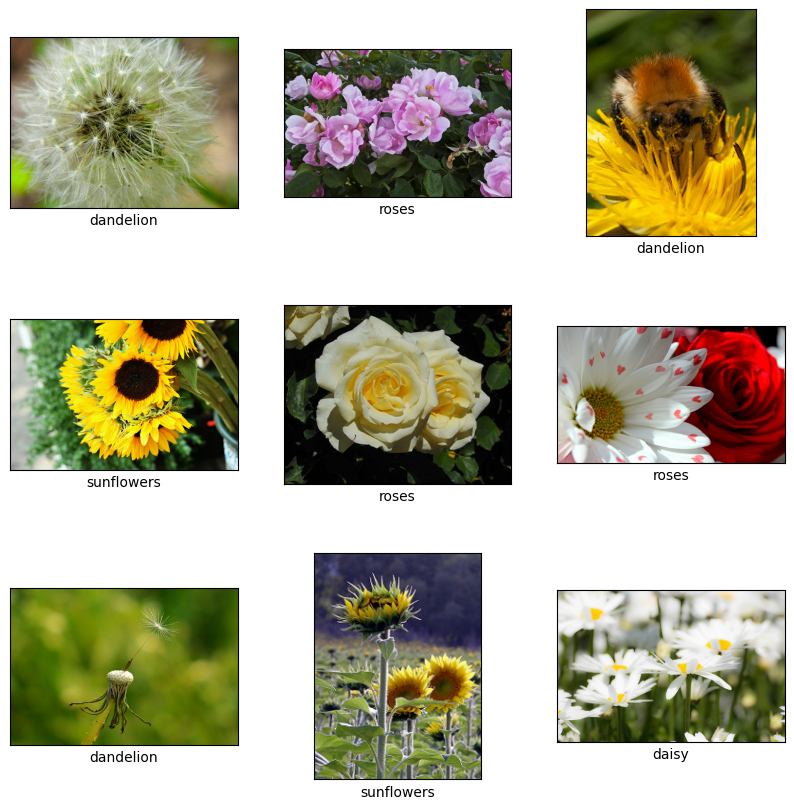

In [116]:
show_images(train_images, 9, train_labels)

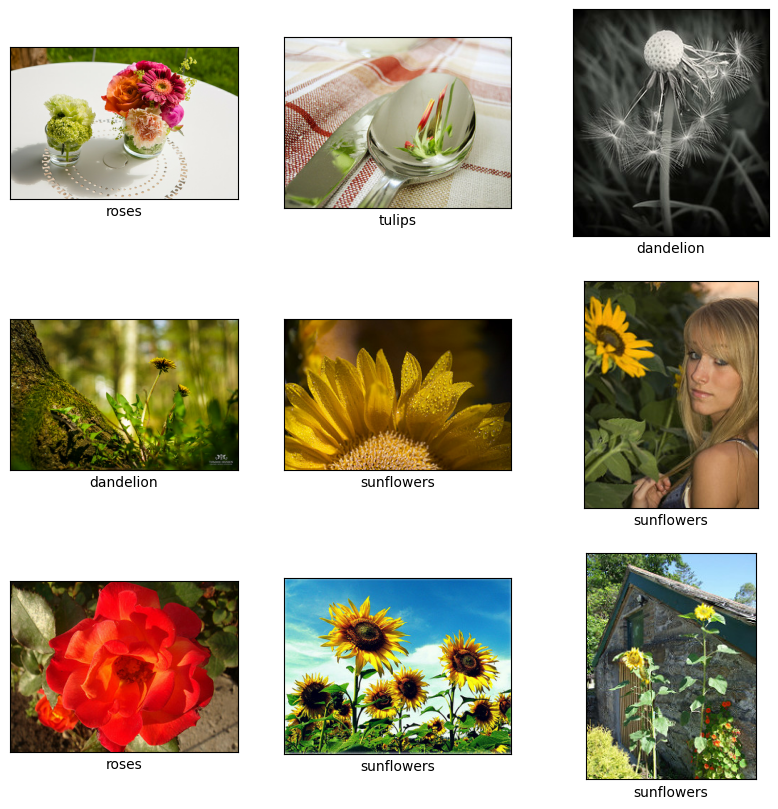

In [117]:
show_images(validation_images, 9, validation_labels)

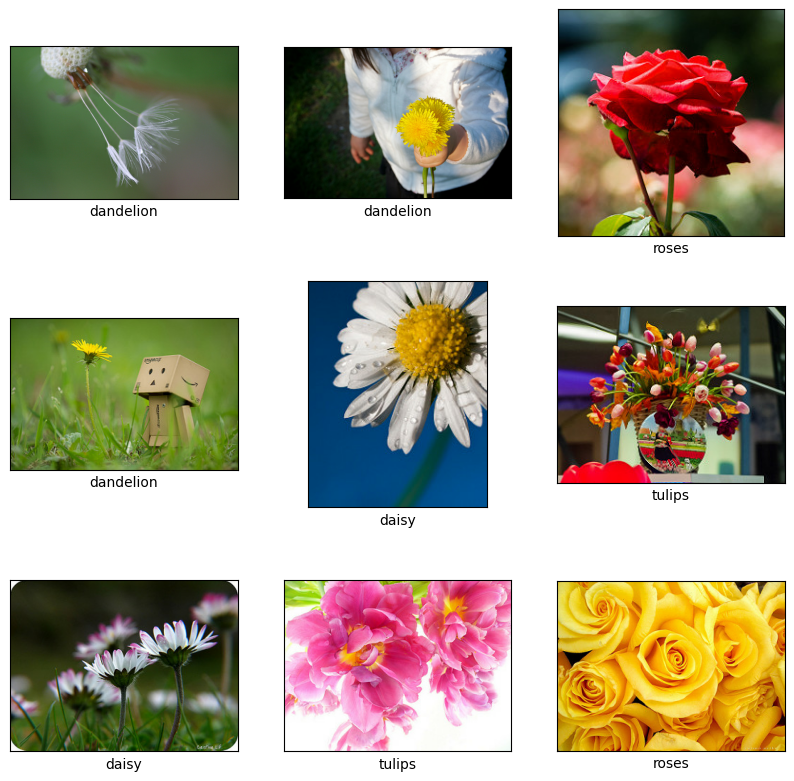

In [118]:
show_images(test_images, 9, test_labels)

### Preprocessing Images

In [119]:
type(train_images[0])

tensorflow.python.framework.ops.EagerTensor

In [120]:
type(train_labels[0])

str

In [127]:
def preprocess_image(image):
    # Resize the image to the shortest side of 224 while maintaining the aspect ratio
    image = tf.image.resize_with_crop_or_pad(image, target_height=224, target_width=224)
    # Convert image to float32 and normalize the pixel values
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

def preprocess_label(label):
    return label

def convert_to_dataset(images, labels):
    # Create a Dataset from the images and labels
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    # Preprocess the dataset
    dataset = dataset.map(lambda image, label: (preprocess_image(image), preprocess_label(label)),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return dataset



In [128]:
# Ensure consistent shapes
assert len(train_images) == len(train_labels)

# Investigate data loading
print(f"Train images shape: {train_images[0].shape}")
print(f"Train labels shape: {train_labels[0].shape}")

# Create the dataset
train_dataset = convert_to_dataset(train_images, train_labels)

InvalidArgumentError: {{function_node __wrapped__Pack_N_2496_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [240,320,3] != values[1].shape = [325,500,3] [Op:Pack] name: component_0

In [125]:
# Create a dictionary to map label strings to integers
label_to_index = {label: index for index, label in enumerate(set(train_labels))}

# Convert the string labels to integers using the mapping
train_labels_int = [label_to_index[label] for label in train_labels]

# Convert the lists to a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels_int))


InvalidArgumentError: {{function_node __wrapped__Pack_N_2496_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [240,320,3] != values[1].shape = [325,500,3] [Op:Pack] name: component_0

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_dataset.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()


In [ ]:
def transform_images(images, labels):
  # Encode the string labels to integer indices
  label_names = sorted(set(labels))  # Get unique labels and sort them
  label_to_index = {label: index for index, label in enumerate(label_names)}
  train_labels_encoded = [label_to_index[label] for label in labels]

  # Convert the lists to a tf.data.Dataset
  dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels_encoded))
  return dataset